# 개인과제-1: 트랜잭션 데이터로부터 직접 파생변수(feature) 만들기
- **Input**: transactions.csv (트랜잭션 형식의 판매 데이터)
- **Output**: features.csv (머신러닝 모델링이 가능한 형태의 고객 feature 데이터, 일명 *Customer Signature*)  

<span style="color:blue">**아래 코드를 참고하여 과제를 수행한 노트북화일(.ipynb)을 기한 내에 가상대학에 제출하기 바랍니다.**</span>  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20)

In [2]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

## Read Transactions

In [3]:
tr = pd.read_csv('transactions.csv', encoding='cp949')
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000


## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [4]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

<br><font color='green'>
### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [5]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))), # round(x) x값에 포함된 소수점 반올림
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액
0,0,68282840,74,922741,11264000
1,1,2136000,3,712000,2136000
2,2,3197000,4,799250,1639000
3,3,16077620,44,365400,4935000
4,4,29050000,3,9683333,24000000
...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900
3496,3496,29628600,13,2279123,7200000
3497,3497,75000,1,75000,75000
3498,3498,1875000,2,937500,1000000


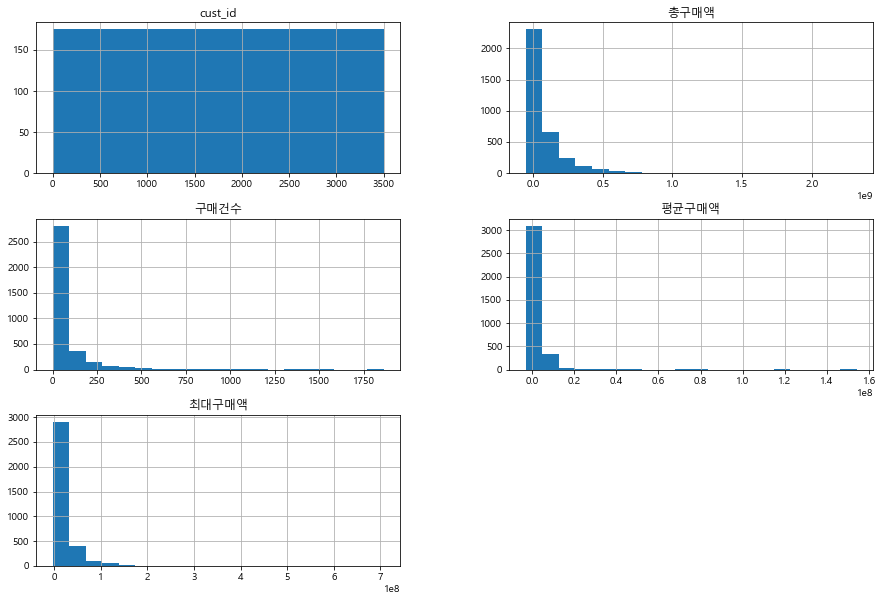

In [6]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [7]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3
0,0,68282840,74,922741,11264000,35,28,17
1,1,2136000,3,712000,2136000,2,2,2
2,2,3197000,4,799250,1639000,1,2,2
3,3,16077620,44,365400,4935000,24,20,13
4,4,29050000,3,9683333,24000000,2,3,3
...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2
3496,3496,29628600,13,2279123,7200000,9,7,5
3497,3497,75000,1,75000,75000,1,1,1
3498,3498,1875000,2,937500,1000000,1,1,1


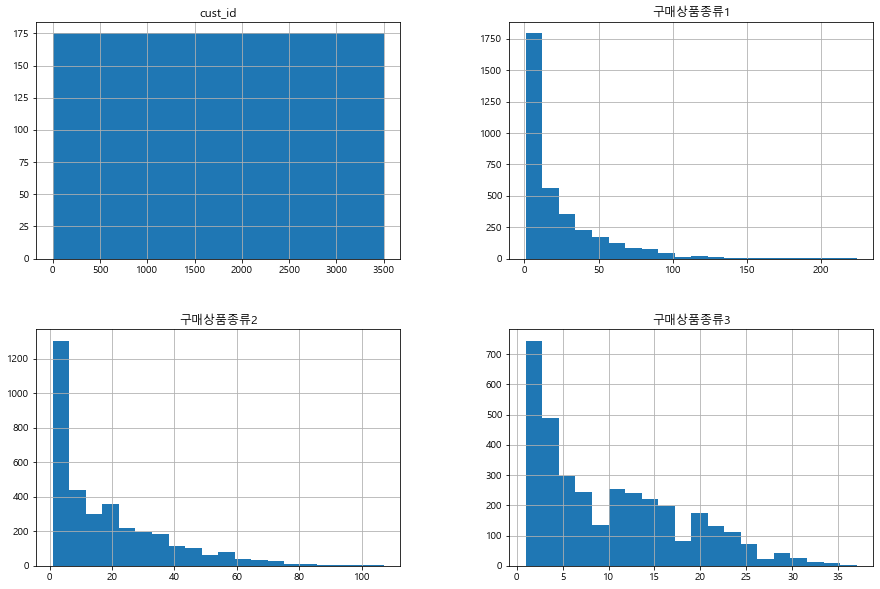

In [8]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [9]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000


**[파생변수 15-16]** 환불금액, 환불건수

In [10]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN


**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [11]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left'); features
# 내점 당 구매건수 = 총구매건수 / 내점일수
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000


**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [12]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features = features.merge(f, how='left'); features

,cust_id,최근3개월_구매금액,최근3개월_구매건수
0,0,29084140,27
1,1,2136000,3
2,3,549620,4
3,4,27000000,2
4,7,140818200,36
...,...,...,...
2439,3492,9154000,1
2440,3493,42697460,101
2441,3494,82800000,2
2442,3496,12028000,7


,cust_id,최근6개월_구매금액,최근6개월_구매건수
0,0,42601240,61
1,1,2136000,3
2,3,1284060,11
3,4,27000000,2
4,6,2250000,2
...,...,...,...
2778,3492,9154000,1
2779,3493,59972640,140
2780,3494,82800000,2
2781,3496,19224000,11


,cust_id,최근12개월_구매금액,최근12개월_구매건수
0,0,68282840,74
1,1,2136000,3
2,2,3197000,4
3,3,16077620,44
4,4,29050000,3
...,...,...,...
3495,3495,3175200,2
3496,3496,29628600,13
3497,3497,75000,1
3498,3498,1875000,2


<br><font color='green'>
### Categorical Features

**[파생변수 25]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [13]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,남성 캐주얼
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,NaN,3.175200e+06,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,7.500000e+04,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,NaN,9.375000e+05,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품


<AxesSubplot:xlabel='count', ylabel='주구매상품'>

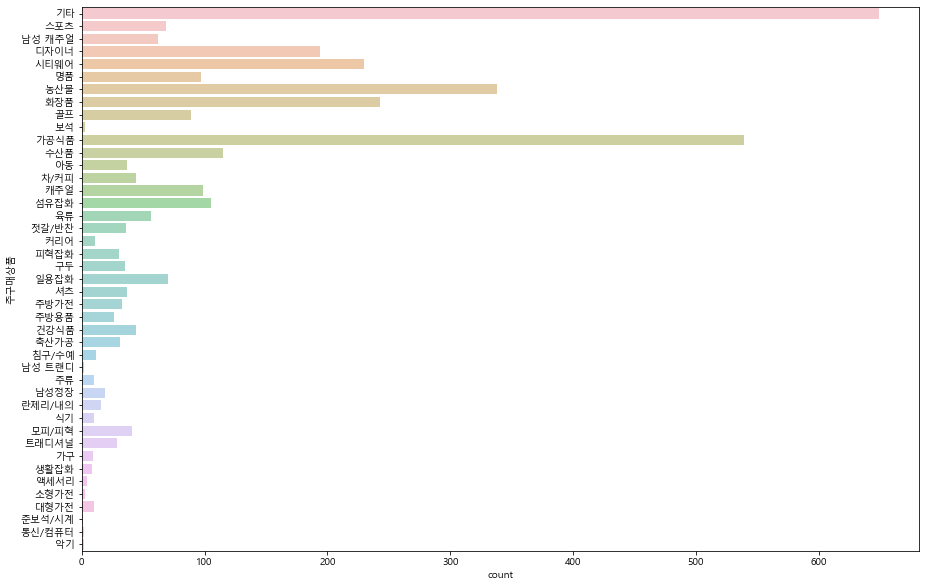

In [14]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='주구매상품', data=f, alpha=0.5)

**[파생변수 26]** 주구매 지점

In [15]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,남성 캐주얼,관악점
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,3.175200e+06,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프,본 점
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,7.500000e+04,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품,창원점
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,9.375000e+05,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품,본 점


<br><font color='red'>
**[파생변수 27-35]** 추가로 새로운 파생변수를 제안하고 구현해야 함! 아래는 예시.
- 구매추세 패턴
- 가격선호도 (예: 고가상품구매율)
- 시즌 선호도
- 휴면(또는 이탈) 여부
- Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
- 상품별 구매순서
- 주구매 요일 

**[파생변수 27]** 주구매 요일 

In [16]:
pd.to_datetime(tr.tran_date).dt.day_name()

0           Friday
1           Friday
2           Friday
3           Friday
4           Friday
            ...   
231999      Monday
232000      Sunday
232001      Sunday
232002    Thursday
232003    Thursday
Name: tran_date, Length: 232004, dtype: object

In [17]:
tr['구매요일'] = pd.to_datetime(tr.tran_date).dt.day_name()
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,구매요일
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,Friday
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000,Friday
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,Friday
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,Friday
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000,Friday
...,...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000,Monday
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000,Sunday
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800,Sunday
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000,Thursday


In [18]:
f = tr.groupby('cust_id')['구매요일'].agg([
    ('주구매요일', lambda x: x.value_counts().index[0])
]).reset_index()

features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,Saturday
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,2.000000,NaN,NaN,NaN,NaN,3197000,4,남성 캐주얼,관악점,Wednesday
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,Tuesday
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프,본 점,Sunday
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품,창원점,Tuesday
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품,본 점,Thursday


**[파생변수 28,29,30]** Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부

In [19]:
tr.gds_grp_mclas_nm.value_counts().index[:10]

Index(['기타', '농산물', '가공식품', '축산가공', '수산품', '화장품', '디자이너', '시티웨어', '일용잡화',
       '육류'],
      dtype='object')

In [20]:
best = tr.gds_grp_mclas_nm.value_counts().index[:10]

In [21]:
f = tr[tr.gds_grp_mclas_nm.isin(best)].groupby('cust_id')['amount'].agg([
    ('best10구매금액', np.sum),
    ('best10구매건수', np.size)
]).reset_index()

features = features.merge(f, how='left')

In [22]:
features.best10구매건수 = features.best10구매건수.fillna(0)
features.best10구매금액 = features.best10구매금액.fillna(0)

In [23]:
def f(x):
    if x == 0:
        return 'N'
    else:
        return 'Y' 
# best 10 구매 했으면 Y 안했으면 N    
features['best10구매여부'] = features.best10구매건수.apply(f)
features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일,best10구매금액,best10구매건수,best10구매여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,42601240.0,61.0,68282840,74,기타,강남점,Saturday,45689940.0,51.0,Y
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday,0.0,0.0,N
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,NaN,3197000,4,남성 캐주얼,관악점,Wednesday,139000.0,2.0,Y
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,1284060.0,11.0,16077620,44,기타,광주점,Tuesday,4411020.0,36.0,Y
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,27000000.0,2.0,29050000,3,기타,본 점,Wednesday,5050000.0,2.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,NaN,NaN,3175200,2,골프,본 점,Sunday,132300.0,1.0,Y
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday,14774000.0,10.0,Y
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,NaN,75000,1,주방용품,창원점,Tuesday,0.0,0.0,N
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,NaN,NaN,1875000,2,화장품,본 점,Thursday,1875000.0,2.0,Y


**[파생변수 31]** 휴면여부

In [24]:
pd.set_option('max_columns', 100, 'max_rows', 20)

In [25]:
features.최근3개월_구매건수 = features.최근3개월_구매건수.fillna(0)
features.최근6개월_구매건수 = features.최근6개월_구매건수.fillna(0)

In [26]:
# 휴면고객은 최근 3개월 동안 구매가 없는 고객을 대상으로 정함.
def f1(x):
    if x == 0:
        return '휴면'
    else:
        return '비휴면'
    
features['휴면여부'] = features.최근3개월_구매건수.apply(f1); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일,best10구매금액,best10구매건수,best10구매여부,휴면여부
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,Saturday,45689940.0,51.0,Y,비휴면
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday,0.0,0.0,N,비휴면
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000,NaN,0.0,NaN,0.0,3197000,4,남성 캐주얼,관악점,Wednesday,139000.0,2.0,Y,휴면
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,Tuesday,4411020.0,36.0,Y,비휴면
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점,Wednesday,5050000.0,2.0,Y,비휴면
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000,NaN,0.0,NaN,0.0,3175200,2,골프,본 점,Sunday,132300.0,1.0,Y,휴면
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday,14774000.0,10.0,Y,비휴면
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000,NaN,0.0,NaN,0.0,75000,1,주방용품,창원점,Tuesday,0.0,0.0,N,휴면
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000,NaN,0.0,NaN,0.0,1875000,2,화장품,본 점,Thursday,1875000.0,2.0,Y,휴면


**[파생변수 32]** 시즌 선호도

In [27]:
# 3,4,5 봄 6,7,8 여름 9,10,11 가을 12,1,2 겨울

def f2(x):
    m = x.month
    if 3 <= m <=5:
        return '봄'
    elif 6 <= m <= 8:
        return '여름'
    elif 9 <= m <= 11:
        return '가을'
    else:
        return '겨울'
    
tr['구매계절'] = pd.to_datetime(tr.tran_date).apply(f2); tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,구매요일,구매계절
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,Friday,겨울
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000,Friday,봄
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,Friday,봄
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,Friday,봄
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000,Friday,봄
...,...,...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000,Monday,겨울
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000,Sunday,겨울
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800,Sunday,겨울
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000,Thursday,겨울


In [28]:
f = tr.groupby('cust_id')['구매계절'].agg([
    ('시즌선호도', lambda x: x.value_counts().index[0])
]).reset_index()

features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일,best10구매금액,best10구매건수,best10구매여부,휴면여부,시즌선호도
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,Saturday,45689940.0,51.0,Y,비휴면,여름
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday,0.0,0.0,N,비휴면,가을
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000,NaN,0.0,NaN,0.0,3197000,4,남성 캐주얼,관악점,Wednesday,139000.0,2.0,Y,휴면,겨울
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,Tuesday,4411020.0,36.0,Y,비휴면,봄
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점,Wednesday,5050000.0,2.0,Y,비휴면,가을
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000,NaN,0.0,NaN,0.0,3175200,2,골프,본 점,Sunday,132300.0,1.0,Y,휴면,여름
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday,14774000.0,10.0,Y,비휴면,가을
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000,NaN,0.0,NaN,0.0,75000,1,주방용품,창원점,Tuesday,0.0,0.0,N,휴면,겨울
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000,NaN,0.0,NaN,0.0,1875000,2,화장품,본 점,Thursday,1875000.0,2.0,Y,휴면,봄


**[파생변수 33, 34]**   여성,남성 상품구매 비율

In [29]:
tr.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,구매요일,구매계절
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,Friday,겨울
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000,Friday,봄
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,Friday,봄
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,Friday,봄
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000,Friday,봄


In [30]:
tr.gds_grp_mclas_nm.unique()

array(['화장품', '시티웨어', '기타', '디자이너', '셔츠', '축산가공', '건강식품', '육류', '수산품',
       '젓갈/반찬', '가공식품', '농산물', '란제리/내의', '스포츠', '섬유잡화', '남성정장', '골프',
       '트래디셔널', '남성 캐주얼', '침구/수예', '일용잡화', '캐주얼', '차/커피', '아동', '구두',
       '보석', '주방용품', '액세서리', '명품', '식기', '주류', '주방가전', '생활잡화', '소형가전',
       '커리어', '피혁잡화', '가구', '모피/피혁', '대형가전', '준보석/시계', '교복', '남성 트랜디',
       '기타의류', '악기', '통신/컴퓨터', '전자/전기', '문구/팬시', '웨딩', '멀티(아울렛)'],
      dtype=object)

In [31]:
# 주구매상품 대분류(롯데백화점 온라인쇼핑몰 참고)
beauty = ['화장품']
etc = ['기타']
fashion_acc = ['구두', '디자이너', '명품', '보석', '섬유잡화', '액세서리', '준보석/시계', '커리어', '트래디셔널', '피혁잡화']
food = ['가공식품', '건강식품', '농산물', '수산품', '육류', '젓갈/반찬', '주류', '차/커피', '축산가공']
kids = ['교복', '문구/팬시', '아동']
living = ['가구', '대형가전', '생활잡화', '소형가전', '식기', '악기', '웨딩', '일용잡화', '전자/전기', '주방가전', '주방용품', '침구/수예', '통신/컴퓨터']
man_fashion = ['남성정장', '남성캐주얼', '남성트랜디', '셔츠']
sports = ['골프', '스포츠']
unisex = ['기타의류', '시티웨어', '캐주얼']
woman_fashion = ['란제리/내의', '멀티(아울렛)', '모피/피혁']

In [32]:
def f3(x):
    if x in(beauty):
        return 'beauty'
    elif x in(etc):
        return 'etc'
    elif x in(fashion_acc):
        return 'fashion_acc'
    elif x in(food):
        return 'food'
    elif x in(kids):
        return 'kids'
    elif x in(living):
        return 'living'
    elif x in(man_fashion):
        return 'man_fashion'
    elif x in(sports):
        return 'sports'
    elif x in(unisex):
        return 'unisex'
    elif x in(woman_fashion):
        return 'woman_fashion'

In [33]:
tr['상품분류'] = tr.gds_grp_mclas_nm.apply(f3)
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,구매요일,구매계절,상품분류
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,Friday,겨울,beauty
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000,Friday,봄,unisex
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,Friday,봄,beauty
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,Friday,봄,unisex
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000,Friday,봄,etc
...,...,...,...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000,Monday,겨울,etc
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000,Sunday,겨울,unisex
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800,Sunday,겨울,food
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000,Thursday,겨울,fashion_acc


In [35]:
# 여성, 남성 상품구매비율 
female = ['beauty','woman_fashion']
male =['man_fashion']
fassion_acc = ['fashion_acc']
f = tr.groupby('cust_id')['상품분류'].agg([
    ('여성상품구매비율', lambda x: np.mean(x.isin(female))),
    ('남성상품구매비율', lambda x: np.mean(x.isin(male))),
    ('패션acc구매비율', lambda x: np.mean(x.isin(fassion_acc)))
]).reset_index()

features = features.merge(f, how='left')
features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일,best10구매금액,best10구매건수,best10구매여부,휴면여부,시즌선호도,여성상품구매비율,남성상품구매비율,패션acc구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,Saturday,45689940.0,51.0,Y,비휴면,여름,0.121622,0.027027,0.108108
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday,0.0,0.0,N,비휴면,가을,0.000000,0.000000,0.333333
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000,NaN,0.0,NaN,0.0,3197000,4,남성 캐주얼,관악점,Wednesday,139000.0,2.0,Y,휴면,겨울,0.000000,0.000000,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,Tuesday,4411020.0,36.0,Y,비휴면,봄,0.000000,0.000000,0.068182
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점,Wednesday,5050000.0,2.0,Y,비휴면,가을,0.333333,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000,NaN,0.0,NaN,0.0,3175200,2,골프,본 점,Sunday,132300.0,1.0,Y,휴면,여름,0.000000,0.000000,0.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday,14774000.0,10.0,Y,비휴면,가을,0.000000,0.076923,0.076923
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000,NaN,0.0,NaN,0.0,75000,1,주방용품,창원점,Tuesday,0.0,0.0,N,휴면,겨울,0.000000,0.000000,0.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000,NaN,0.0,NaN,0.0,1875000,2,화장품,본 점,Thursday,1875000.0,2.0,Y,휴면,봄,1.000000,0.000000,0.000000


In [41]:
tr.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,구매요일,구매계절,상품분류
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,Friday,겨울,beauty
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000,Friday,봄,unisex
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,Friday,봄,beauty
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,Friday,봄,unisex
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000,Friday,봄,etc


In [45]:
# 고가상품구매율 
# 상위 10% 이상의 상품이 고가상품이라 선정


value = tr.amount.quantile(0.9)
value

3634000.0

In [57]:
f = tr[tr.amount >= value].groupby('cust_id')['amount'].agg([('고가상품구매건수', 'size')]).reset_index()
features = features.merge(f, how='left')

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일,best10구매금액,best10구매건수,best10구매여부,휴면여부,시즌선호도,여성상품구매비율,남성상품구매비율,패션acc구매비율,고가상품구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,Saturday,45689940.0,51.0,Y,비휴면,여름,0.121622,0.027027,0.108108,7.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday,0.0,0.0,N,비휴면,가을,0.000000,0.000000,0.333333,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000,NaN,0.0,NaN,0.0,3197000,4,남성 캐주얼,관악점,Wednesday,139000.0,2.0,Y,휴면,겨울,0.000000,0.000000,0.000000,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,Tuesday,4411020.0,36.0,Y,비휴면,봄,0.000000,0.000000,0.068182,2.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점,Wednesday,5050000.0,2.0,Y,비휴면,가을,0.333333,0.000000,0.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000,NaN,0.0,NaN,0.0,3175200,2,골프,본 점,Sunday,132300.0,1.0,Y,휴면,여름,0.000000,0.000000,0.000000,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday,14774000.0,10.0,Y,비휴면,가을,0.000000,0.076923,0.076923,5.0
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000,NaN,0.0,NaN,0.0,75000,1,주방용품,창원점,Tuesday,0.0,0.0,N,휴면,겨울,0.000000,0.000000,0.000000,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000,NaN,0.0,NaN,0.0,1875000,2,화장품,본 점,Thursday,1875000.0,2.0,Y,휴면,봄,1.000000,0.000000,0.000000,NaN


In [60]:
features['고가상품구매율'] = features['고가상품구매건수']/features['구매건수']
features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일,best10구매금액,best10구매건수,best10구매여부,휴면여부,시즌선호도,여성상품구매비율,남성상품구매비율,패션acc구매비율,고가상품구매건수,고가상품구매율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,Saturday,45689940.0,51.0,Y,비휴면,여름,0.121622,0.027027,0.108108,7.0,0.094595
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday,0.0,0.0,N,비휴면,가을,0.000000,0.000000,0.333333,NaN,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000,NaN,0.0,NaN,0.0,3197000,4,남성 캐주얼,관악점,Wednesday,139000.0,2.0,Y,휴면,겨울,0.000000,0.000000,0.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,Tuesday,4411020.0,36.0,Y,비휴면,봄,0.000000,0.000000,0.068182,2.0,0.045455
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점,Wednesday,5050000.0,2.0,Y,비휴면,가을,0.333333,0.000000,0.333333,1.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000,NaN,0.0,NaN,0.0,3175200,2,골프,본 점,Sunday,132300.0,1.0,Y,휴면,여름,0.000000,0.000000,0.000000,NaN,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday,14774000.0,10.0,Y,비휴면,가을,0.000000,0.076923,0.076923,5.0,0.384615
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000,NaN,0.0,NaN,0.0,75000,1,주방용품,창원점,Tuesday,0.0,0.0,N,휴면,겨울,0.000000,0.000000,0.000000,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000,NaN,0.0,NaN,0.0,1875000,2,화장품,본 점,Thursday,1875000.0,2.0,Y,휴면,봄,1.000000,0.000000,0.000000,NaN,NaN


<br><font color='green'>
### Feature Correlation

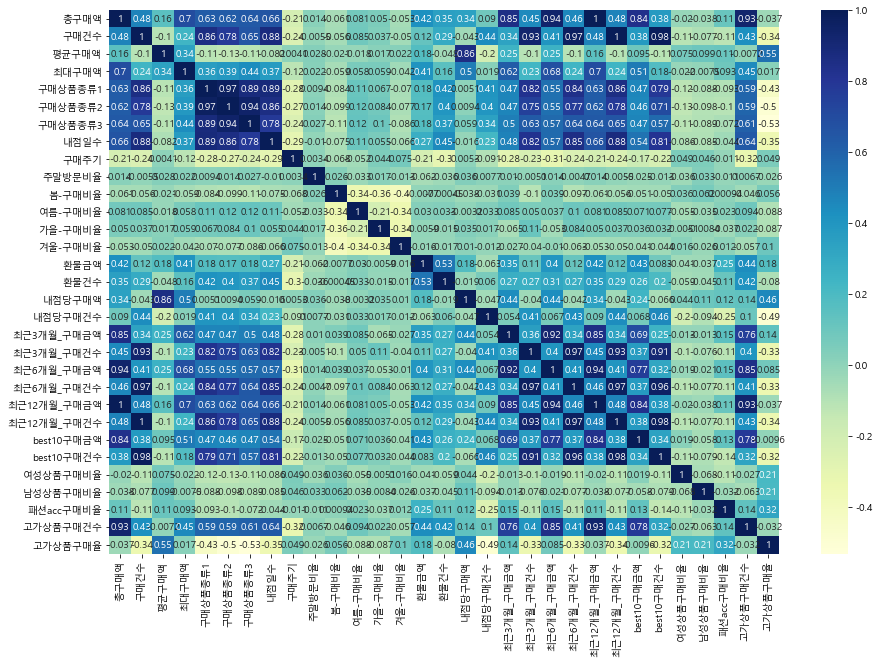

In [62]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(15,10))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 CSV 화일로 만들어진다.

In [64]:
display(features)
features.to_csv('features.csv', index=False, encoding='cp949')
features.info()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,주구매요일,best10구매금액,best10구매건수,best10구매여부,휴면여부,시즌선호도,여성상품구매비율,남성상품구매비율,패션acc구매비율,고가상품구매건수,고가상품구매율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점,Saturday,45689940.0,51.0,Y,비휴면,여름,0.121622,0.027027,0.108108,7.0,0.094595
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점,Thursday,0.0,0.0,N,비휴면,가을,0.000000,0.000000,0.333333,NaN,NaN
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000,NaN,0.0,NaN,0.0,3197000,4,남성 캐주얼,관악점,Wednesday,139000.0,2.0,Y,휴면,겨울,0.000000,0.000000,0.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점,Tuesday,4411020.0,36.0,Y,비휴면,봄,0.000000,0.000000,0.068182,2.0,0.045455
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,기타,본 점,Wednesday,5050000.0,2.0,Y,비휴면,가을,0.333333,0.000000,0.333333,1.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000,NaN,0.0,NaN,0.0,3175200,2,골프,본 점,Sunday,132300.0,1.0,Y,휴면,여름,0.000000,0.000000,0.000000,NaN,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점,Saturday,14774000.0,10.0,Y,비휴면,가을,0.000000,0.076923,0.076923,5.0,0.384615
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000,NaN,0.0,NaN,0.0,75000,1,주방용품,창원점,Tuesday,0.0,0.0,N,휴면,겨울,0.000000,0.000000,0.000000,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000,NaN,0.0,NaN,0.0,1875000,2,화장품,본 점,Thursday,1875000.0,2.0,Y,휴면,봄,1.000000,0.000000,0.000000,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cust_id      3500 non-null   int64  
 1   총구매액         3500 non-null   int64  
 2   구매건수         3500 non-null   int64  
 3   평균구매액        3500 non-null   int64  
 4   최대구매액        3500 non-null   int64  
 5   구매상품종류1      3500 non-null   int64  
 6   구매상품종류2      3500 non-null   int64  
 7   구매상품종류3      3500 non-null   int64  
 8   내점일수         3500 non-null   int64  
 9   구매주기         3500 non-null   int64  
 10  주말방문비율       3500 non-null   float64
 11  봄-구매비율       3500 non-null   float64
 12  여름-구매비율      3500 non-null   float64
 13  가을-구매비율      3500 non-null   float64
 14  겨울-구매비율      3500 non-null   float64
 15  환불금액         1205 non-null   float64
 16  환불건수         1205 non-null   float64
 17  내점당구매액       3500 non-null   float64
 18  내점당구매건수      3500 non-null   float64
 19  최근3개월_

# End